In [193]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import networkx as nx
import matplotlib.pyplot as plt
import operator
eps = np.finfo(float).eps  #the smallest  representable number to avoid log 0 or 0 in the denominator
from networkx.drawing.nx_agraph import graphviz_layout
G = nx.DiGraph()
nodes=[]
edges=[]
leaf=[]

In [194]:
#calculate entropy for the whole dataset using target attribute Fast
def find_entropy(dframe):
    Class = dframe.keys()[-1]
    entropy=0
    values = dframe[Class].unique() #get unique values no or yes
    for value in values:
        probability = dframe[Class].value_counts()[value]/len(dframe[Class])
        entropy += -probability*np.log2(probability) 
    return entropy

In [195]:
#return entropy for each attribute
def find_entropy_for_attribute(dframe,attribute):
    Class = dframe.keys()[-1] #the target output class
    entropy=0
    attr_list=list(dframe[attribute])
    merged_class=list(zip(attr_list,list(dframe[Class])))
    class_attr_list=set(merged_class)#get number of unique classes in attribute
    all_classes= list(class_attr_list)
    sub_entropy = 0
    for x in all_classes:
        probability = merged_class.count(x)/attr_list.count(x[0])
        #print(attr_list.count(x[0]),len(attr_list),probability,math.log2(probability))
                #entropy of child combinations
        sub_entropy = probability*math.log2(probability)
        entropy-=(attr_list.count(x[0])/len(attr_list))*(sub_entropy)
    return abs(entropy)

In [206]:
def find_max_ig(dframe):
    IG = [] #list to hold information gain for the attributes
    for key in dframe.keys()[:-1]:
        IG.append(find_entropy(dframe) - find_entropy_for_attribute(dframe,key))
    print(dframe.keys()[:-1][np.argmax(IG)])
    return dframe.keys()[:-1][np.argmax(IG)] 

In [207]:
def get_subtable(dframe, node, value):#splitting into subtables according to node attribute and atrribute values
    return dframe[dframe[node] == value].reset_index(drop=True)

In [224]:
def buildTree(dframe,tree= None):
    Class=dframe.keys()[-1] #target output fast
    node = find_max_ig(dframe) #attribute with highest information gain
    distinct_values = np.unique(dframe[node]) #distinct value of the attribute with the highest IG
    #empty dictionary to create tree
    if tree is None:
        tree = {}
        tree[node] = {}

    #construct tree through a loop by recursive call of this function
    #reducing dataset,splitting into branches
    for value in distinct_values:
        subtable= get_subtable(dframe,node,value)
        print(subtable)
        clValue,counts = np.unique(subtable['fast'],return_counts=True)
        print(counts)
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]  
            
    print(tree)
#         else:        
#             tree[node][value] = buildTree(subtable) #atCalling the function recursively 
                   
    return tree

In [225]:
data_headers=['engine','turbo','weight','fueleco','fast']
data=pd.read_csv("id3_data.csv",names=data_headers,header=None)


In [226]:
tree= buildTree(data)
import pprint
pprint.pprint(tree)


fueleco
  engine turbo   weight  fueleco fast
0  small    no    light  average   no
1  small    no  average  average   no
2  small   yes  average  average   no
[3]
   engine turbo   weight fueleco fast
0   small   yes  average     bad  yes
1  medium    no    heavy     bad  yes
2   large   no   average     bad  yes
3  medium    no    light     bad   no
4   large   yes    heavy     bad   no
5   large    no    heavy     bad   no
6  medium   yes    light     bad  yes
7   large    no  average     bad  yes
8  medium    no    heavy     bad   no
9  medium    no    heavy     bad   no
[5 5]
  engine turbo   weight fueleco fast
0  small    no  average    good   no
1  small    no    light    good   no
[2]
{'fueleco': {'average': 'no', 'good': 'no'}}
{'fueleco': {'average': 'no', 'good': 'no'}}


In [173]:
keys=list(tree.keys())
keys

['fueleco']

In [174]:
def drawtree(tree):
    set1 = set()
    set2 = set()

    for k,v in tree.items():
        set1.add(k)
        for key in v:
            set2.add(key)
            leaf=list(v.values())
    nodes=list(set1)  
    edges =list(set2)      
    print("Nodes--> "+' '.join(map(str, nodes)))
    print("edges--> "+','.join(map(str, edges)))
    print("leaf--> "+','.join(map(str, leaf)))    
    # G.add_nodes_from(nodes)
    # sorted(G.nodes(),key=str)
    # edges_tuple= [(x,) for x in edges] #list comprehension 
#     print(leaf)

    # G.add_nodes_from(nodes)
    newlist= zip(nodes,leaf)
    newlist
    if (len(nodes)==1 and len(leaf)==2):
        G.add_edge(nodes[0],leaf[0])
        G.add_edge(nodes[0],leaf[1])
    pos = nx.spring_layout(G)
    nx.draw(G,pos,node_size=200,node_color='#68fd00');     


Nodes--> fueleco
edges--> average,good
leaf--> no,no


C:\Users\Richard Mbingi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Richard Mbingi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


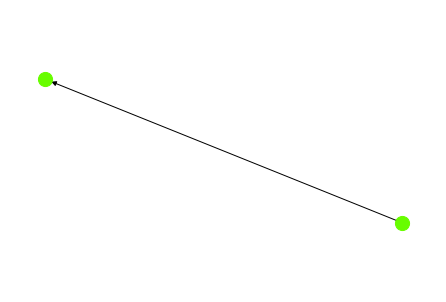

In [176]:
drawtree(tree)

In [180]:
def predict(inst,tree):
    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
    return prediction

In [181]:
inst = data.iloc[6]

In [183]:
# prediction = predict(inst, tree)